In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import cv2
from PIL import Image
from transformers import BertTokenizer
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
from collections import Counter

IMAGE PRE-PROCESSING

In [2]:
def preprocess_image(image_path,target_size=(224,224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    if img_array.ndim == 2 : #gray-scale edge case
        img_array = np.stack([img_array]*3,axis = -1)
    return img_array
    

LOADING MSCOCO DATASET JSON FILES

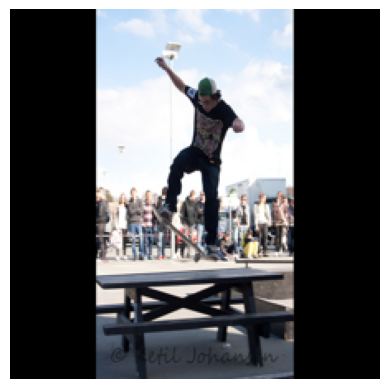

Question: Where is he looking?


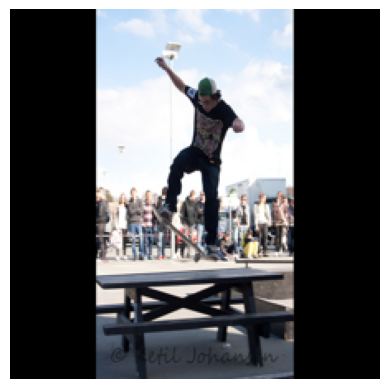

Question: What are the people in the background doing?


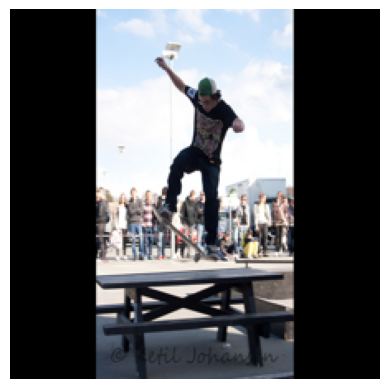

Question: What is he on top of?


In [ ]:
# Load questions
with open('v2_OpenEnded_mscoco_val2014_questions.json', 'r') as f:
    questions_data = json.load(f)

N = 50000

# Optionally: Displaying images/questions for sanity check
for i,question_obj in enumerate(questions_data['questions'][:N]):
    image_id = question_obj['image_id']
    img_filename = f"COCO_val2014_{image_id:012d}.jpg"
    img_path = f"val2014/{img_filename}"

    if not os.path.exists(img_path):
        print('Missing path:',img_path)
        continue

    img_arr = preprocess_image(img_path)
    question_text = question_obj['question']

    # selecting first 3
    if i < 3:
        plt.imshow(img_arr)
        plt.axis('off')
        plt.show()
        print("Question:", question_text)

EXTRACTING IMAGE FEATURES

In [ ]:
# Loading pretrained ResNet50 without top classification layer, using global avg pool
resnet_model = ResNet50(weights = 'imagenet',include_top = False,pooling = 'avg')
image_folder = './val2014'

# Enabling mixed precision to speed up GPU computations
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

def load_and_prep_img(img_path):
    img = preprocess_image(img_path)           
    img = preprocess_input(img)  # ResNet normalization
    return img

# full image paths, filter out missing files
image_ids = [q["image_id"] for q in questions_data["questions"][:N]]
image_paths = [os.path.join(image_folder, f'COCO_val2014_{img_id:012d}.jpg') for img_id in image_ids]
existing_paths = [p for p in image_paths if os.path.exists(p)]

#Creating tf.data.Dataset for efficient streaming
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(existing_paths)
dataset = dataset.map(lambda x : tf.numpy_function(load_and_prep_img,[x],tf.float32),
                      num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
X_img = resnet_model.predict(dataset, verbose = 1)
print("Feature array shape:", X_img.shape)

'''
#Without using tf.data and autotune
#Extracting features function for batch of image_ids
def extract_image_features_batch(image_ids,batch_size = 32):
    img_arrays = []
    valid_ids = []
    for img_id in image_ids:
        image_id = question_obj['image_id']
        img_filename = f"COCO_val2014_{image_id:012d}.jpg"
        img_path = f"val2014/{img_filename}"

        if not os.path.exists(img_path):
            print('Missing path:',img_path)
            continue

        img_arr = preprocess_image(img_path)
        img_arrays.append(img_arr)
        valid_ids.append(img_id)

    img_arrays = np.array(img_arrays)
    img_arrays = preprocess_input(img_arrays) # ResNet normalization

    features = []
    for i in range(0,len(img_arrays),batch_size):
        batch = img_arrays[i:i+batch_size]
        batch_features = resnet_model.predict(batch)
        features.append(batch_features)

    features = np.concatenate(features,axis = 0)
    return features,valid_ids

# Usage
image_ids = [q["image_id"] for q in questions_data["questions"][:N]]
X_img , valid_ids = extract_image_features_batch(image_ids,batch_size = 32)
print("Image features shape:", X_img.shape)'''
        
        

TEXT PRE-PROCESSING

In [ ]:
# Loading the pretrained BERT tokenizer (vocabulary and splitting rules)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

N = 50000
question_texts = [q['question'] for q in questions_data['questions'][:N]]

# Tokenize all questions as a batch
tokenized_questions = tokenizer(
    question_texts,  # List of questions
    return_tensors = 'tf', # Output as tensorflow tensors 
    padding = 'max_length', # Pad all to same length
    max_length = 32, # Standardize sequence length for batching
    truncation = True  # Cut off questions that are too long
)

X_txt = tokenized_questions['input_ids']

print("First Tokenized Question IDs:", X_txt[0])
print("Original Text:", question_texts[0])



FETCH GROUND TRUTH ANSWERS FOR QUESTIONS

In [ ]:
with open('v2_mscoco_val2014_annotations.json', 'r') as f:
    val_annotations = json.load(f)

N = 50000

for i,question_obj in enumerate(questions_data['questions'][:N]):
    question_id = question_obj['question_id']
    #Finding annotation for this question
    ann = next((a for a in val_annotations['annotations'] if a['question_id'] == question_id),None)

    if ann is None:
        print(f"No answer to question_id:{question_id}")
        continue

    answers = [ans['answer'] for ans in ann['answers']]

    if i<3:
        print(f"Question:{question_obj['question']}")
        print(f"Answers: {answers}")
        print('---')

    

    

BUILDING A SIMPLE BASELINE MODEL

In [ ]:
#Collecting unique answers in the sample
N = 50000
all_answers = [ans['answer'] for ann in val_annotations['annotations'][:N] 
                for ans in ann['answers']]

# Getting the most common answers as the label set (top K often improves baseline)
top_k = 500
answer_freq = Counter(all_answers)
top_answers = [a for a, _ in answer_freq.most_common(top_k)]
ans_w_idx = {a:i for i,a in enumerate(top_answers)}

# Function to map each set of answers to a label 
def map_ans_to_idx(answers):
    for ans in answers:
        if ans['answer'] in ans_w_idx:
            return ans_w_idx[ans['answer']]
    return -1

y_labels = []
for ann in val_annotations['annotations'][:N]:
    idx = map_ans_to_idx(ann['answers'])
    y_labels.append(idx)
y_labels = np.array(y_labels)
                
# Filter inputs (X_img, X_txt) and y_labels with valid labels only
valid_indices = np.where(y_labels != -1)[0]
X_img = X_img[valid_indices]
X_txt = X_txt.numpy()[valid_indices]
y_labels = y_labels[valid_indices]

print(f"Training on {len(y_labels)} samples and {top_k} answer classes")

In [ ]:
unique_labels, counts = np.unique(y_labels, return_counts=True)
print("Unique labels:", unique_labels)
print("Counts per label:", counts)
print("Number of classes used:", len(unique_labels))

In [ ]:
embedding_dim = 128
num_classes = len(top_answers)  # Number of answer classes from label encoding
question_length = tokenized_questions['input_ids'].shape[1]
image_feature_dim = X_img.shape[1]

# Defining inputs
img_input = layers.Input(shape = (image_feature_dim,),name = 'img_features')
txt_input = layers.Input(shape=(question_length,), dtype='int32', name='question_tokens')

#Image feature branch
img_branch = layers.Dense(256,activation = 'relu')(img_input)
img_branch = layers.BatchNormalization()(img_branch)
img_branch = layers.Dropout(0.3)(img_branch)
img_branch = layers.Dense(embedding_dim, activation='relu')(img_branch)
img_branch = layers.Dropout(0.3)(img_branch)

# Text feature branch: embedding + average pooling + dense + dropout
embedding_layer = layers.Embedding(input_dim = tokenizer.vocab_size,output_dim = embedding_dim)
txt_embed = embedding_layer(txt_input)
txt_pool = layers.GlobalAveragePooling1D()(txt_embed)
txt_branch = layers.Dense(256, activation='relu')(txt_pool)
txt_branch = layers.BatchNormalization()(txt_branch)
txt_branch = layers.Dropout(0.3)(txt_branch)
txt_branch = layers.Dense(embedding_dim, activation='relu')(txt_pool)
txt_branch = layers.Dropout(0.3)(txt_branch)

# Concatenating features and classifying
combined = layers.Concatenate()([img_branch,txt_branch])
combined = layers.Dense(256, activation='relu')(combined)
combined = layers.BatchNormalization()(combined)
combined = layers.Dropout(0.4)(combined)
combined = layers.Dense(embedding_dim, activation='relu')(combined)
combined = layers.Dropout(0.4)(combined)
output = layers.Dense(num_classes, activation='softmax')(combined)

# Build and compile model
model = models.Model(inputs = [img_input,txt_input],outputs = output)

#Optimization
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

#Training the model
history = model.fit([X_img, X_txt], y_labels,
                    epochs=15,
                    batch_size=64,
                    validation_split = 0.15,
                    callbacks = [early_stop,reduce_lr],
                    verbose = 1)




EVALTUTE AND SAVE THE MODEL

In [ ]:
val_loss , val_accuracy = model.evaluate([X_img,X_txt],y_labels)
print(f"\nFinal Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

model.save('vqa_baseline_model.h5')
print("Model saved to vqa_baseline_model.h5")

BATCH PREDICTIONS ON ALL SAMPLES

In [ ]:
predictions = model.predict([X_img,X_txt])
prediction_indices = np.argmax(predictions,axis = 1)
predicted_answers = [top_answers[idx] if idx < len(top_answers) else 'unknown' for idx in predicted_indices]

SINGLE SAMPLE PREDICTION FUNCTION AND SAMPLE PREDICTION

In [ ]:
def predict_answer(image_feature, question_tokens):
    preds = model.predict([np.expand_dims(image_feature, axis=0),
                           np.expand_dims(question_tokens, axis=0)])
    pred_class = np.argmax(preds)
    return top_answers[pred_class]

sample_idx = 0
predicted_answer = predict_answer(X_img[sample_idx], X_txt[sample_idx])
true_label_idx = y_labels[sample_idx]
true_answer = top_answers[true_label_idx] if true_label_idx >= 0 else 'N/A'

print(f"\nExample Prediction:")
print(f"Predicted answer: {predicted_answer}")
print(f"True answer: {true_answer}")


VISUALISATION

In [ ]:
def visualize_prediction(image_id, question_text, predicted_ans, true_ans):
    img_filename = f"COCO_val2014_{image_id:012d}.jpg"
    img_path = os.path.join("val2014", img_filename)
    
    if os.path.exists(img_path):
        img = plt.imread(img_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Question: {question_text}\nPrediction: {predicted_ans}\nTrue answer: {true_ans}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Image not found: {img_path}")

image_id_example = questions_data['questions'][sample_idx]['image_id']
question_text_example = questions_data['questions'][sample_idx]['question']
visualize_prediction(image_id_example, question_text_example, predicted_answer, true_answer)


MULTIPLE PREDICTIONS WITH GROUND TRUTH AND ACCURACY CALCULATION

In [ ]:
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

num_examples = 10
for i in range(min(num_examples, len(y_labels))):
    question_id = questions_data['questions'][i]['question_id']
    question_text = questions_data['questions'][i]['question']
    
    ann = next((a for a in val_annotations['annotations'] if a['question_id'] == question_id), None)
    true_answers = [ans['answer'] for ans in ann['answers']] if ann else ['N/A']
    
    is_correct = predicted_answers[i] in true_answers
    
    print(f"\n{i+1}. Question: {question_text}")
    print(f"   Predicted: {predicted_answers[i]}")
    print(f"   Ground Truth: {true_answers}")
    print(f"   Result: {'✓ CORRECT' if is_correct else '✗ WRONG'}")

correct = sum(1 for i in range(len(y_labels)) 
              if predicted_answers[i] in [ans['answer'] 
                                          for ans in next((a for a in val_annotations['annotations'] 
                                                          if a['question_id'] == questions_data['questions'][i]['question_id']), 
                                                         {'answers': []})['answers']])

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Total samples: {len(y_labels)}")
print(f"Number of answer classes: {len(top_answers)}")
print(f"Correct predictions: {correct}/{len(y_labels)}")
print(f"Overall accuracy: {(correct/len(y_labels))*100:.2f}%")
print("="*60)
